
# Unlearning Concepts in Diffusion Models with SAeUron

# Introduction

Diffusion models have transformed generative modeling by enabling high-quality image synthesis. However, these models can unintentionally produce undesirable or restricted content — such as explicit material, copyrighted imagery, or biased representations

**Concept unlearning** aims to selectively remove the ability of a model to generate specific concepts, without retraining the entire network

In this tutorial, we implement [SAeUron](https://arxiv.org/pdf/2501.18052), a method that uses Sparse Autoencoders (SAEs) to identify and steer the internal activations of a diffusion model so that features associated with a given concept are suppressed. SAeUron’s key strengths are:

- Interpretability — We can explicitly see which features correspond to the target concept.

- Minimal Side Effects — The rest of the model’s generative ability remains intact.

The central question we explore is:

- **Can we steer a diffusion model to “forget” a specific concept while preserving other capabilities?**

We will:

1. Load Stability AI’s SDXL-Turbo model (lightweight yet high-quality).

2. Use a pretrained Sparse Autoencoder targeting a specific U-Net block.

3. Identify features most correlated with a chosen concept.

4. Ablate those features during inference to prevent concept generation.

## Install Dependencies

In [ ]:
%%bash

pip install -U nnsight
pip install msgspec ftfy python-socketio[client]
git clone https://github.com/surkovv/sdxl-unbox.git
pip install clip_retrieval
pip install -r sdxl-unbox/colab_requirements.txt

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 100.2/100.2 kB 12.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 93.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 59.6/59.6 kB 7.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.5/79.5 kB 10.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 224.9/224.9 kB 22.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.8/44.8 kB 5.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 88.3/88.3 kB 10.8 MB/s eta 0:00:00
  Preparing metadata (setup.py): started
  Preparing metadata (setup.py): finished with status 'done'
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.0/61.0 kB 7.9 MB/s eta 0:00:00
INFO: pip is looking at multiple versions of opencv-python-headless to determine which version is compatible with other requirements. This could take a while.
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 343.6/343.6 kB 35.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━

Cloning into 'sdxl-unbox'...
Updating files: 100% (38/38), done.
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
shap 0.50.0 requires numpy>=2, but you have numpy 1.26.4 which is incompatible.
jaxlib 0.7.2 requires numpy>=2.0, but you have numpy 1.26.4 which is incompatible.
opencv-python 4.12.0.88 requires numpy<2.3.0,>=2; python_version >= "3.9", but you have numpy 1.26.4 which is incompatible.
pytensor 2.35.1 requires numpy>=2.0, but you have numpy 1.26.4 which is incompatible.
jax 0.7.2 requires numpy>=2.0, but you have numpy 1.26.4 which is incompatible.
opencv-contrib-python 4.12.0.88 requires numpy<2.3.0,>=2; python_version >= "3.9", but you have numpy 1.26.4 which is incompatible.


## Restart Session to ensure compatible version are used

In [ ]:
import os, signal
os.kill(os.getpid(), signal.SIGKILL)

## Load Model

In [ ]:
import torch
from nnsight.modeling.diffusion import DiffusionModel
from IPython.display import clear_output

# GPU check
if torch.cuda.is_available():
    DEVICE = "cuda:0"
    print("GPU connected")
else:
    DEVICE = "cpu"
    print("GPU NOT connected")

# FP16 recommended for SDXL Turbo
DTYPE = torch.float16

# Load SDXL-Turbo with NNsight instrumentation
model = DiffusionModel(
    "stabilityai/sdxl-turbo",
    torch_dtype=DTYPE,
    dispatch=True,
).to(DEVICE)

clear_output()
print("NNsight + SDXL Turbo ready!")


NNsight + SDXL Turbo ready!


## Downloading Sparse Autoencoder Checkpoints
We’ll now fetch the pretrained SAE weights.

These were trained on a **specific cross-attention block** of SDXL-Turbo (`unet.up_blocks.0.attentions.1`), and will be used to encode and decode activations at that point in the network.

In [ ]:
import os

os.makedirs("/content/checkpoints", exist_ok=True)
!wget -O /content/checkpoints/config.json https://github.com/surkovv/sdxl-unbox/blob/main/checkpoints/unet.up_blocks.0.attentions.1_k10_hidden5120_auxk256_bs4096_lr0.0001/final/config.json
!wget -O /content/checkpoints/mean.pt https://github.com/surkovv/sdxl-unbox/blob/main/checkpoints/unet.up_blocks.0.attentions.1_k10_hidden5120_auxk256_bs4096_lr0.0001/final/mean.pt
!wget -O /content/checkpoints/state_dict.pth https://github.com/surkovv/sdxl-unbox/blob/main/checkpoints/unet.up_blocks.0.attentions.1_k10_hidden5120_auxk256_bs4096_lr0.0001/final/state_dict.pth
!wget -O /content/checkpoints/std.pt https://github.com/surkovv/sdxl-unbox/blob/main/checkpoints/unet.up_blocks.0.attentions.1_k10_hidden5120_auxk256_bs4096_lr0.0001/final/std.pt

clear_output()

## Loading SAE

A Sparse Autoencoder (SAE) learns to reconstruct the activation space of a diffusion model, but in a way where only a few latent features are active at a time (sparsity).
These features often align with semantically meaningful concepts in the generated images.

We will use Sparse Autoencoders trained [here](https://github.com/surkovv/sdxl-unbox) for the identification of features.

In [ ]:
%cd sdxl-unbox

/content/sdxl-unbox


In [ ]:
import matplotlib.pyplot as plt
from SAE import SparseAutoencoder


@torch.no_grad()
def nnsight_compatible_decode_sparse(self, inds, vals):
    decoder_vectors = self.decoder.weight.T.to(DEVICE, DTYPE)
    gathered_vectors = decoder_vectors[inds]
    weighted_vectors = gathered_vectors * vals.unsqueeze(-1)
    recons = weighted_vectors.sum(dim=1)
    recons = recons + self.pre_bias.to(DEVICE, DTYPE)
    return recons

SparseAutoencoder.decode_sparse = nnsight_compatible_decode_sparse

path_to_checkpoints = './checkpoints/'
BLOCK_ID = "unet.up_blocks.0.attentions.1"

sae = SparseAutoencoder.load_from_disk(
    os.path.join(path_to_checkpoints, f"{BLOCK_ID}_k10_hidden5120_auxk256_bs4096_lr0.0001", "final")
).to('cuda', dtype=DTYPE)

clear_output()

## Define some utility function
- To get the activation of the diffusion model
- To encode the activation with SAE (basically bring the activations to high dimensional sparse vectors, where each activated value select a feature from the decoder of SAE)

In [ ]:
STEP_SIZE = 4

@torch.no_grad()
def get_feature_activations(prompt, sae, seed=42, steps=STEP_SIZE):
    with model.generate(prompt, seed=seed, num_inference_steps=STEP_SIZE) as tracer:
          outputs = list().save()
          attention_module = model.unet.up_blocks[0].attentions[1]
          with tracer.all():
            outputs.append(attention_module.output[0][1])

    c, h, w = outputs[0].shape

    flat = torch.cat([
        a.permute(1,2,0).reshape(-1, c)
        for a in outputs
    ], dim=0)

    return sae.encode(flat.to(torch.float16))

# Let's get to the fun part.
We will divide the unlearning process into different phase

# Phase 1 – Identifying Concept-Specific Features

## Description
Let define a score for each SAE feature that measures how much it "lights up" for our target concept \( c \) compared to unrelated prompts.

## Formula (From the paper)
$$ score(i, t, c, D) = \frac{\mu(i, t, D_c)}{\sum_{j=1}^n \mu(j, t, D_c) + \delta} - \frac{\mu(i, t, D_{\sim c})}{\sum_{j=1}^n \mu(j, t, D_{\sim c}) + \delta} $$

## Definitions
- $\mu(i, t, D)$ = average activation of feature $i$ at timestep $t$ for dataset $D$
- $D_c$ = prompts with concept $c$
- $D_{\sim c}$ = prompts without concept $c$
- $\delta$ = small constant to avoid division by zero
- $n$ = total number of SAE features

## Interpretation:
A high score means “this feature is active for
𝑐, but not for other concepts.”

In [ ]:
def collect_stats(sae, Dc_prompts, D_not_c_prompts, step_size=4, seed=42):
    acts_c, acts_not_c = [], []

    for p in Dc_prompts:
        acts_c.append(get_feature_activations(p, sae, seed, step_size))

    for p in D_not_c_prompts:
        acts_not_c.append(get_feature_activations(p, sae, seed, step_size))

    acts_c = torch.cat(acts_c, dim=0)
    acts_not_c = torch.cat(acts_not_c, dim=0)

    return acts_c, acts_not_c


def compute_concept_scores(acts_c, acts_not_c):
    mu_c = acts_c.abs().mean(dim=0)
    mu_not_c = acts_not_c.abs().mean(dim=0)

    denom_c = mu_c.sum() + 1e-12
    denom_not_c = mu_not_c.sum() + 1e-12

    score = (mu_c / denom_c) - (mu_not_c / denom_not_c)
    return score, mu_c, mu_not_c

# Phase 2 - Selecting Top Features
Once we have scores, we keep only the top $\tau_c$ features with the highest score.\
We also remove:
- **Dead features** - activated in $< 1\%$ of cases.
- **Overactive features** - activated in $> 99\%$ of cases.

From the paper:

$$ F_c := \{i \mid i \in \text{Top-}\tau_c(\text{score}(i, t, c, D))\} $$

In [ ]:
# Dead: very low freq; overactive: too high freq
dead_threshold = 0.01
overactive_threshold = 0.99
SEED = 42
τc = 5

def get_top_features(Dc_prompts, D_not_c_prompts, τc=5, seed=0):
    acts_c, acts_not_c = collect_stats(sae, Dc_prompts, D_not_c_prompts)
    score, mu_c, mu_not_c = compute_concept_scores(acts_c, acts_not_c)

    # === Compute frequency ===
    freq_c = (acts_c.abs() > 0).float().mean(dim=0)
    freq_not_c = (acts_not_c.abs() > 0).float().mean(dim=0)
    freq = (freq_c + freq_not_c) / 2

    valid_mask = (freq > dead_threshold) & (freq < overactive_threshold)

    masked_score = score.clone()
    masked_score[~valid_mask] = -9999   # don't select invalid features

    top_scores, top_indices = torch.topk(masked_score, τc)
    # top_indices[0].item() # For single feature intervention
    return top_indices.tolist(), mu_c, mu_not_c


# Phase 3 - Ablating Features During Inference

## Option 1 (This is what is use in the SAeUron paper)

During generation, for every **denoising step**:
- Encode activations using the SAE.
- If a feature $i \in F_c$ is active **above its average activation**, scale it by a negative multiplier $\gamma_c < 0$.
- Decode back into the activation space and pass it to the next block.

$$ f_i(x) =
\begin{cases}
      \gamma_c \mu(i, t, D_c)f_i(x), & \text{if } i \in F_c \land f_i(x) > \mu(i, t, D) \\
      f_i(x), & \text{otherwise}
\end{cases} $$

In [ ]:
@torch.no_grad()
def ablate_inference_sae(
    F_c,                # list of concept-relevant features (indices)
    mu_c,               # μ(i, t, D_c)
    mu_not_c,           # μ(i, t, D_~c)
    prompt,
    gamma_c = -3.0,
    seed = 42,
):

    block = model.unet.up_blocks[0].attentions[1]

    # μ(i,t,D) = global average activation
    mu_global = (mu_c + mu_not_c) / 2

    with model.generate(
        prompt,
        seed=seed,
        num_inference_steps=STEP_SIZE,
        guidance_scale=0.0
    ) as tracer:

        # apply interventions at every denoising step
        with tracer.all():

            # get block activation for batch=1 path only
            x = block.output[0][0]   # shape [C, H, W]
            C, H, W = x.shape

            # flatten spatial dims
            flat = x.permute(1,2,0).reshape(-1, C)   # [HW, C]

            # SAE encode (dense)
            latents = sae.encode(flat.to(torch.float16))  # [HW, K]

            # modify each concept feature
            for feat in F_c:
                mu_feat_c = mu_c[feat]
                mu_feat_g = mu_global[feat]

                # rule: only modify if f_i(x) > μ(i,t,D)
                mask = latents[:, feat] > mu_feat_g

                # scaling rule from paper:
                latents[mask, feat] = latents[mask, feat] * gamma_c * mu_feat_c

            # dense decode:
            decoded = latents @ sae.decoder.weight.T + sae.pre_bias  # [HW, C]

            # reshape back to [C, H, W]
            decoded = decoded.reshape(H, W, C).permute(2,0,1)

            # write back into the block output
            block.output[0][0][:] = decoded

        out = tracer.result.save()

    return out.images[0]

### Example 1: Let's unlearn a cat (no offense to Cat).

Define prompts which include and doesn't include cat.

In [ ]:
Dc_prompts = [
    "A serene forest landscape with a curious cat",
    "A cat lounging on a windowsill, watching birds outside",
    "A whimsical illustration of a cat in a fairy tale scene",
    "A cat playing with a ball of yarn in a cozy living room",
    "A cat riding a bicycle down a country road",
    "A majestic cat sitting on a throne, regal attire",
    "A cat exploring a mysterious ancient temple",
    "A cat enjoying a warm cup of coffee on a patio",
    "A cat chasing after butterflies in a garden",
    "A cat curled up with a good book in a library",
]

D_not_c_prompts = [
    "A serene forest landscape",
    "A windowsill scene, with birds outside",
    "A whimsical illustration of a fairy tale scene",
    "A ball of yarn in a cozy living room",
    "A bicycle riding down a country road",
    "A majestic throne with regal attire",
    "A mysterious ancient temple",
    "A warm cup of coffee on a patio",
    "Butterflies in a garden",
    "A good book in a library",
]

- Obtain the desired feature
- Generate an image with same prompt that has cat in it after the steering

In [ ]:
feature_to_ablate, mu_c, mu_not_c = get_top_features(Dc_prompts, D_not_c_prompts, τc=5, seed=0)
clear_output()

In [ ]:
img_ablated = ablate_inference_sae(feature_to_ablate, mu_c, mu_not_c, Dc_prompts[0], -1)
clear_output()

In [ ]:
with model.generate(Dc_prompts[0], seed=SEED, num_inference_steps=STEP_SIZE, guidance_scale=0.0):
    output = model.output.save()

img_original = output.images[0]
clear_output()

(-0.5, 511.5, 511.5, -0.5)

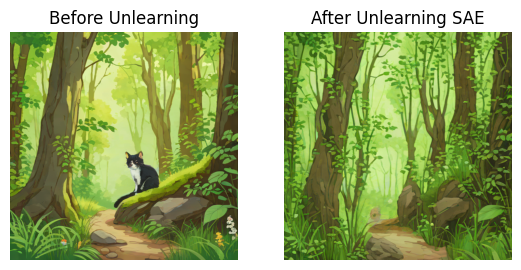

In [ ]:
plt.figure(figsize=(10, 5))

plt.subplot(1, 3, 1)
plt.imshow(img_original)
plt.title("Before Unlearning")
plt.axis("off")

plt.subplot(1, 3, 2)
plt.imshow(img_ablated)
plt.title("After Unlearning SAE")
plt.axis("off")

### Example 2: How about Towers

In [ ]:
CONCEPT = "Towers"

Dc_prompts = [
    "A medieval stone tower standing tall amidst a foggy landscape",
    "A clock tower rising above a bustling city square, people walking by",
    "A futuristic observation tower made of glass and steel in a modern city",
    "A magical wizard’s tower in a fantasy landscape, surrounded by mystical clouds",
    "A lighthouse tower guiding ships safely into a harbor",
    "A crumbling ancient watchtower in the middle of a forgotten ruin",
    "A tall radio tower transmitting signals across a vast countryside",
    "A defensive guard tower overlooking the entrance of a fortress",
    "A water tower standing alone beside a quiet rural road",
    "A majestic bell tower crowning a hilltop in a scenic landscape",
]

D_not_c_prompts = [
    "A medieval castle standing tall amidst a foggy landscape",
    "A bustling city square with a marketplace, people walking by",
    "A futuristic skyscraper made of glass and steel in a modern city",
    "A magical fortress in a fantasy landscape, surrounded by mystical clouds",
    "A lighthouse guiding ships safely into a harbor",
    "A crumbling ancient temple in the middle of a forgotten ruin",
    "A signal transmitter station spreading signals across a vast countryside",
    "A defensive wall overlooking the entrance of a fortress",
    "A windmill standing alone beside a quiet rural road",
    "A majestic monastery crowning a hilltop in a scenic landscape",
]


In [ ]:
feature_to_ablate

[2208, 3483, 566, 1696, 3111]

In [ ]:
feature_to_ablate, mu_c, mu_not_c = get_top_features(Dc_prompts, D_not_c_prompts, τc=5)

clear_output()

In [ ]:
feature_to_ablate

[1101, 4197, 5003, 500, 3176]

A medieval stone tower standing tall amidst a foggy landscape


  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

(-0.5, 511.5, 511.5, -0.5)

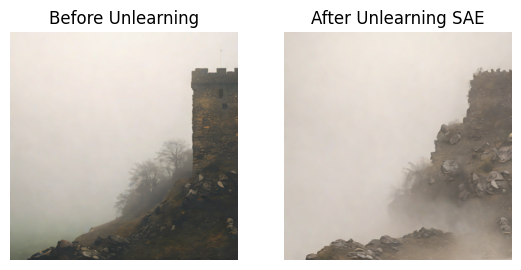

In [ ]:
prompt = Dc_prompts[0]
print(prompt)

with model.generate(prompt, seed=SEED, num_inference_steps=STEP_SIZE, guidance_scale=0.0):
    output = model.output.save()

img_original_ = output.images[0]

img_ablated_ = ablate_inference_sae(feature_to_ablate, mu_c, mu_not_c, prompt, -0.1)

plt.figure(figsize=(10, 5))

plt.subplot(1, 3, 1)
plt.imshow(img_original_)
plt.title("Before Unlearning")
plt.axis("off")

plt.subplot(1, 3, 2)
plt.imshow(img_ablated_)
plt.title("After Unlearning SAE")
plt.axis("off")

### (Bonus) Evaluation of Unlearning Accuracy

Let's calculate the unlearning accuracy for in-domain image generation by using ViT classifer

In [ ]:
!pip install -U gdown

file_id = "1As5OJW1ygWPSL6rOw-9RNmeYEFhlW_qH"

!gdown --id $file_id -O style50_cls.pth

!pip install "anyio==4.4.0"

!pip install --upgrade timm

clear_output()

In [ ]:
from PIL import Image
from tqdm import tqdm
import timm
from torchvision import transforms

### Load the Classifier

In [ ]:
# Paths
ckpt_path = './style50_cls.pth'

class_available = ["Architectures", "Bears", "Birds", "Butterfly", "Cats", "Dogs", "Fishes", "Flame", "Flowers",
                   "Frogs", "Horses", "Human", "Jellyfish", "Rabbits", "Sandwiches", "Sea", "Statues", "Towers",
                   "Trees", "Waterfalls"]

objects_to_test = ["Cats", "Towers"]

# Load model
model_cls = timm.create_model('vit_large_patch16_224.augreg_in21k', pretrained=True)
model_cls.head = torch.nn.Linear(1024, len(class_available) )
model_cls.load_state_dict(torch.load(ckpt_path, weights_only=False, map_location=DEVICE)["model_state_dict"])
model_cls = model_cls.to(DEVICE)
model_cls.eval()
clear_output()

In [ ]:
transform = transforms.Compose([
    transforms.Resize((224,224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5]*3, std=[0.5]*3),
])

def classify_images(images):
    preds = []
    for img in images:
        tensor = transform(img).unsqueeze(0).to(DEVICE)
        pred = model_cls(tensor)
        label = torch.argmax(pred, dim=1).item()
        preds.append(label)
    return preds

class_idx_per_object = { s: class_available.index(s) for s in objects_to_test }

- **Define prompts with and without the objects**
- **Get the top feature for the objects**

In [ ]:
Dc_prompts_per_object = {
    "Cats": [
        "A serene forest landscape with a curious cat",
        "A cat lounging on a windowsill, watching birds outside",
        "A whimsical illustration of a cat in a fairy tale scene",
        "A cat playing with a ball of yarn in a cozy living room",
        "A cat riding a bicycle down a country road",
        "A majestic cat sitting on a throne, regal attire",
        "A cat exploring a mysterious ancient temple",
        "A cat enjoying a warm cup of coffee on a patio",
        "A cat chasing after butterflies in a garden",
        "A cat curled up with a good book in a library",
    ],
    "Towers": [
      "A medieval tower standing tall amidst a foggy landscape",
      "A clock tower in a bustling city square, people walking by",
      "A futuristic tower made of glass and steel in a modern city",
      "A tower in a fantasy landscape, surrounded by mystical clouds",
      "A lighthouse tower guiding ships safely into a harbor",
      "A crumbling ancient tower in a forgotten ruin",
      "A tower of books stacked haphazardly in a library",
      "A radio tower transmitting signals across a vast countryside",
      "A tower of blocks built by a child in a playground",
      "A majestic tower crowning a hilltop in a scenic landscape",
  ]
}


D_not_c_prompts = [
    "A serene forest landscape",
    "A windowsill scene, with birds outside",
    "A whimsical illustration of a fairy tale scene",
    "A ball of yarn in a cozy living room",
    "A bicycle riding down a country road",
    "A majestic throne with regal attire",
    "A mysterious ancient temple",
    "A warm cup of coffee on a patio",
    "Butterflies in a garden",
    "A good book in a library",
    "A medieval structure standing tall amidst a foggy landscape",
    "A bustling city square, people walking by",
    "A futuristic building made of glass and steel in a modern city",
    "A fantasy landscape, surrounded by mystical clouds",
    "A lighthouse guiding ships safely into a harbor",
    "A crumbling ancient ruin",
    "A stack of books haphazardly piled in a library",
    "A signal transmitting across a vast countryside",
    "Blocks built by a child in a playground",
    "A majestic structure crowning a hilltop in a scenic landscape"
]

top_features_per_object = {}

for object in objects_to_test:
    Dc_prompts = Dc_prompts_per_object[object]
    feature_to_ablate, mu_c, mu_not_c = get_top_features(Dc_prompts, D_not_c_prompts, τc=5, seed=0)

    top_features_per_object[object] = {}
    top_features_per_object[object]["top_feature"] = feature_to_ablate
    top_features_per_object[object]["mu"] = mu_c
    top_features_per_object[object]["mu_not_c"] = mu_not_c

    clear_output()

### Generate with prompts that include the objects

In [ ]:
all_results = {}

for object in objects_to_test:
    Dc_prompts = Dc_prompts_per_object[object]
    feature_to_ablate = top_features_per_object[object]["top_feature"]
    mu_c = top_features_per_object[object]["mu"]
    mu_not_c = top_features_per_object[object]["mu_not_c"]


    ablated = []
    for prompt in Dc_prompts:
        ablated_ = ablate_inference_sae(feature_to_ablate, mu_c, mu_not_c, prompt, -0.1)
        ablated.append(ablated_)

    all_results[object] = ablated

clear_output()

### Calculate Accuracy

In [ ]:
ua_per_object = {}

for object in objects_to_test:
    ablated = all_results[object]
    expected_idx = class_idx_per_object[object]

    ablate_preds = classify_images(ablated)
    ua = sum([p != expected_idx for p in ablate_preds]) / len(ablate_preds)
    ua_per_object[object] = ua
    print(f"[UA] {object}: {ua*100:.2f}% (higher is better)")

[UA] Cats: 70.00% (higher is better)
[UA] Towers: 90.00% (higher is better)


## Sweeping over the negative multiplier

In [ ]:
multipliers = [-0.001, -0.01 -0.5, -0.1, -3.0, -5.0]
ua_results = {}

for m in multipliers:
    all_results = {}
    for obj in objects_to_test:
        Dc_prompts = Dc_prompts_per_object[obj]
        feature_to_ablate = top_features_per_object[obj]["top_feature"]
        mu_c = top_features_per_object[obj]["mu"]
        mu_not_c = top_features_per_object[obj]["mu_not_c"]

        ablated = [ablate_inference_sae(feature_to_ablate, mu_c, mu_not_c, p, m)
                   for p in Dc_prompts]
        all_results[obj] = ablated

    ua_per_object = {}
    for obj in objects_to_test:
        expected_idx = class_idx_per_object[obj]
        preds = classify_images(all_results[obj])
        ua = sum([p != expected_idx for p in preds]) / len(preds)
        ua_per_object[obj] = ua
    ua_results[m] = ua_per_object
    print(f"Multiplier {m} → {ua_per_object}")

clear_output()

In [ ]:
ua_results

{-0.001: {'Cats': 0.6, 'Towers': 0.8},
 -0.51: {'Cats': 0.7, 'Towers': 0.8},
 -0.1: {'Cats': 0.7, 'Towers': 0.9},
 -3.0: {'Cats': 0.9, 'Towers': 1.0},
 -5.0: {'Cats': 1.0, 'Towers': 1.0}}

## Overall Quality Preservation evaluation

The clip scores between the original and ablated image is used as the metric for the quality preservation

In [ ]:
import open_clip
clip_model, _, preprocess = open_clip.create_model_and_transforms("ViT-B-32", pretrained="openai")
clip_model = clip_model.to(DEVICE)
clear_output()

In [ ]:
@torch.no_grad()
def clip_similarity(images_a, images_b):
    sims = []
    for img_a, img_b in zip(images_a, images_b):
        t_a = preprocess(img_a).unsqueeze(0).to(DEVICE)
        t_b = preprocess(img_b).unsqueeze(0).to(DEVICE)
        feat_a = clip_model.encode_image(t_a)
        feat_b = clip_model.encode_image(t_b)
        sim = torch.nn.functional.cosine_similarity(feat_a, feat_b).item()
        sims.append(sim)
    return sum(sims) / len(sims)

In [ ]:
quality_scores = {}

for obj in objects_to_test:
  Dc_prompts = Dc_prompts_per_object[obj]

  originals = []
  for prompt in Dc_prompts:
    with model.generate(prompt, seed=SEED, num_inference_steps=STEP_SIZE, guidance_scale=0.0):
      originals.append(model.output.images[0])

  quality_scores[obj] = {}

  for m in [-0.5, -1]:
      feature_to_ablate = top_features_per_object[obj]["top_feature"]
      mu_c = top_features_per_object[obj]["mu"]
      mu_not_c = top_features_per_object[obj]["mu_not_c"]

      ablated = []
      for prompt in Dc_prompts:
          ablated_ = ablate_inference_sae(feature_to_ablate, mu_c, mu_not_c, prompt, m)
          ablated.append(ablated_)

      quality_scores[obj][m] = clip_similarity(originals, ablated)

clear_output()
import pprint
print("Quality preservation: ")
pprint.pprint(quality_scores, width=50, sort_dicts=False)

Quality preservation: 
{'Cats': {-0.5: 0.8501905977725983,
          -1: 0.822922146320343},
 'Towers': {-0.5: 0.8035015285015106,
            -1: 0.735317176580429}}


### **Even though we get higher unlearning accuracy as magnitude of negative multilpier increase, the quality also decrease significantly**

# Slider

Ablated Image (multiplier = -1.02 )


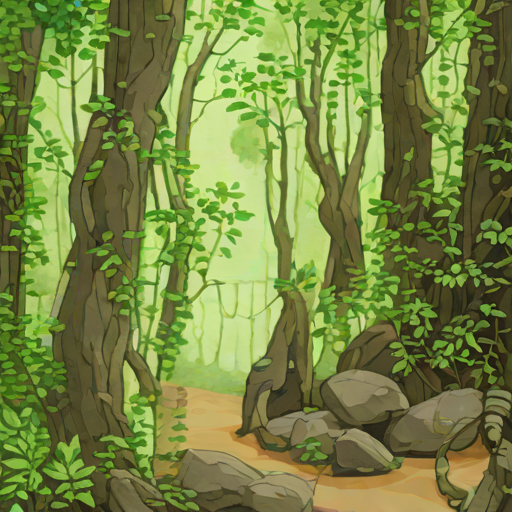

FloatSlider(value=-1.02, continuous_update=False, description='Neg Mult:', max=1.0, min=-2.0, step=0.01)

In [ ]:
import ipywidgets as widgets
from IPython.display import display, clear_output

prompt = "A serene forest landscape with a curious cat"

feature_to_ablate = top_features_per_object["Cats"]["top_feature"]
mu_c = top_features_per_object["Cats"]["mu"]
mu_not_c = top_features_per_object["Cats"]["mu_not_c"]

with model.generate(prompt, seed=SEED, num_inference_steps=STEP_SIZE, guidance_scale=0.0):
    img_original = model.output.images[0]

print("Original Image:")
display(img_original)

def run_ablation(multiplier):
    ablated_img = ablate_inference_sae(
        feature_to_ablate,
        mu_c,
        mu_not_c,
        prompt,
        multiplier
    )

    clear_output(wait=True)
    print("Ablated Image (multiplier =", multiplier, ")")
    display(ablated_img)
    display(slider)

def on_button_click(b):
    clear_output(wait=True)
    print("Ablated mode activated. Use the slider to adjust negative_multiplier.")
    run_ablation(slider.value)

button = widgets.Button(description="Ablated")
slider = widgets.FloatSlider(
    value=-0.05,
    min=-2.0,
    max=1,
    step=0.01,
    description="Neg Mult:",
    continuous_update=False
)

slider.observe(lambda change: run_ablation(change['new']) if change['name'] == 'value' else None, names='value')
button.on_click(on_button_click)

display(button)